In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-pack

In [3]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

In [4]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
tstamp = '1600397251'
#df = pd.read_sql("SELECT * FROM queries WHERE timestamp > 1600397251", con=connection)
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
df = pd.concat([df,grav_df])

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.columns)

Index(['id', 'timestamp', 'type', 'status', 'domain', 'client', 'forward',
       'additional_info', 'blocked'],
      dtype='object')


In [5]:
def make_mask(x):
    y = np.zeros(100)
    y[:x] = 1
    return y

def make_multilabel(x):
    x_ = list(map(lambda xx: int(xx),x.split(' ')))
    y = np.zeros(100)
    y[range(len(x_))] = x_
    return y

In [32]:
#import sentencepiece as spm

# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
#spm.SentencePieceTrainer.train('--input=domains.txt --model_prefix=m --vocab_size=5000')

# makes segmenter instance and loads the model file (m.model)
#sp = spm.SentencePieceProcessor()
#sp.load('m.model')


import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "yttm_ads.model"

# Generating random file with training data
# 10000 lines with 100 characters in each line
#n_lines = 10000
#n_characters = 100
#with open(train_data_path, "w") as fout:
#    for _ in range(n_lines):
#        print("".join([random.choice("abcd ") for _ in range(n_characters)]), file=fout)

# Generating random text
test_text = "".join([random.choice("abcde ") for _ in range(100)])

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=500, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(df.domain.values[:2]), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[:5]), output_type=yttm.OutputType.SUBWORD))

[[83, 135, 250, 157, 234, 76, 66, 12, 94, 10, 419, 439, 100], [83, 135, 250, 157, 234, 76, 66, 12, 94, 10, 419, 439, 100]]
[['▁m', 'ob', 'ile', '.p', 'ip', 'e.', 'ar', 'i', 'a.', 'm', 'icro', 'sof', 't.com'], ['▁m', 'ob', 'ile', '.p', 'ip', 'e.', 'ar', 'i', 'a.', 'm', 'icro', 'sof', 't.com'], ['▁t', 'ele', 'metr', 'y', '.d', 'rop', 'box.com'], ['▁', 'login', '.li', 'v', 'e.com'], ['▁', 'edg', 'e.', 'sk', 'yp', 'e.com']]


In [81]:
df_ = df.loc[df.client=='192.168.0.147'].reset_index()
df_['timestamp'] = df_.timestamp.round(-3)
df_dom = df_.groupby(['timestamp','domain']).count().reset_index()

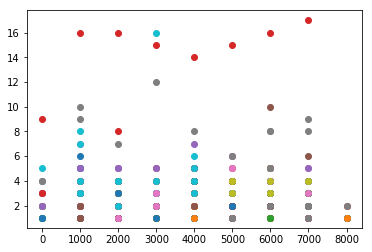

In [100]:
for dom in df_dom.domain.unique():
    df_dom_i = df_dom.loc[df_dom.domain==dom].reset_index()
    pl.plot(df_dom_i.timestamp.unique()-df_.timestamp.unique().min(),df_dom_i['index'],'o')

In [21]:
format_df = df.groupby('timestamp').sum().reset_index()
format_df['domain'] = df.groupby('timestamp')['domain'].apply(lambda x: ' '.join(x)).reset_index()['domain']
format_df['domain_list'] = df.groupby('timestamp')['domain'].apply(lambda x: ','.join(x)).reset_index()['domain']
format_df['mask_count'] = df.groupby('timestamp')['domain'].apply(lambda x: len(x)).reset_index()['domain']
#format_df['domain'] = format_df['domain'].apply(lambda x: ' '.join(x.split('.')))
format_df['blocked_chain'] = df.groupby('timestamp')['blocked'].apply(lambda x: ' '.join([str(int(i)) for i in x])).reset_index()['blocked']

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.text import Tokenizer
#tokenize = Tokenizer()

encoded_docs = pad_sequences(list(bpe.encode(list(format_df.domain.values), output_type=yttm.OutputType.ID)),100,padding='post')#map(sp.encode_as_ids,format_df.domain.values)),100,padding='post')
masks = np.array(list(map(make_mask,format_df.mask_count)))
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

In [36]:
from tensorflow.keras.layers import Embedding,Dense,Input,Flatten,Concatenate
from tensorflow.keras import Model

In [37]:
def test_model():
    input_domains = Input(shape=(100,))
    input_mask = Input(shape=(100,))
    embed = Embedding(501,64)(input_domains)
    dense1 = Dense(64,activation='relu')(Flatten()(embed))
    
    dense_mask = Dense(32,activation='relu')(input_mask)
    concat_dense = Concatenate()([dense1,dense_mask])
    
    output = Dense(100,activation='sigmoid')(concat_dense)
    model = Model(inputs=[input_domains,input_mask],outputs=output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [38]:
tm = test_model()

In [39]:
train,test = train_test_split(range(len(encoded_docs)))

In [40]:
tm.fit([encoded_docs[train],masks[train]],labels[train],validation_data=([encoded_docs[test],masks[test]],labels[test]),epochs=30)

Train on 2580 samples, validate on 860 samples
Epoch 1/30
2580/2580 [==============================] - 1s 302us/sample - loss: 0.1598 - acc: 0.9326 - val_loss: 0.0155 - val_acc: 0.9948
Epoch 2/30
2580/2580 [==============================] - 0s 166us/sample - loss: 0.0158 - acc: 0.9943 - val_loss: 0.0124 - val_acc: 0.9953
Epoch 3/30
2580/2580 [==============================] - 1s 252us/sample - loss: 0.0114 - acc: 0.9959 - val_loss: 0.0088 - val_acc: 0.9971
Epoch 4/30
2580/2580 [==============================] - 0s 183us/sample - loss: 0.0084 - acc: 0.9969 - val_loss: 0.0073 - val_acc: 0.9974
Epoch 5/30
2580/2580 [==============================] - 0s 152us/sample - loss: 0.0068 - acc: 0.9974 - val_loss: 0.0065 - val_acc: 0.9976
Epoch 6/30
2580/2580 [==============================] - 0s 192us/sample - loss: 0.0057 - acc: 0.9979 - val_loss: 0.0061 - val_acc: 0.9977
Epoch 7/30
2580/2580 [==============================] - 1s 210us/sample - loss: 0.0049 - acc: 0.9982 - val_loss: 0.0059 - val

In [59]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x):
        encoded_docs = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),100,padding='post').reshape(1,100)
        masks = np.array(make_mask(1)).reshape(1,100)
        return self.ml_model.predict([encoded_docs,masks])
        
mw = model_wrapper(tm,bpe)
mw.predict('adserv.microsoft.com')[0][0]

0.79227614

In [725]:
masks = np.array(list(map(make_mask,format_df.mask_count)))

In [726]:
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

[0]
[0, 0, 0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0, 0, 0, 1, 1, 0, 0]
[1, 0]
[1, 1]
[1]
[0, 0]
[0]
[1, 1, 0]
[1]
[0]
[1, 1]
[1]
[0]
[0]
[1, 1, 0, 0]
[0, 1]
[0, 0, 0]
[0]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0]
[1, 1]
[0]
[0, 1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 1, 0, 0]
[0, 1, 0]
[0]
[0, 0, 0, 0]
[1, 1]
[1]
[1, 1, 0]
[1]
[1, 1]
[1]
[0]
[1, 1]
[1]
[0]
[1, 1]
[1, 0]
[1]
[0]
[0]
[1, 1]
[0, 1]
[0, 1, 1, 1]
[0]
[0]
[1, 1]
[1]
[1, 1]
[1, 0]
[0]
[1, 1]
[1, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[1, 1, 0, 0, 0, 0]
[0, 1]
[1, 1]
[1, 1, 0]
[1, 0]
[1, 1]
[0, 1]
[0, 0]
[1]
[0, 0, 0]
[0]
[1, 1]
[1]
[1]
[0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1, 0, 1, 0, 1]
[0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1, 1, 0, 0]
[0, 1]
[0]
[0, 0, 1, 1, 1]
[0]
[0]
[0]
[0]
[0]
[1, 1, 0]
[0, 1, 0]
[0, 1, 1]
[1]
[0]
[1, 1]
[0, 1]
[0]
[0, 0, 1, 0]
[1, 0, 0]
[0, 0, 0]
[0]
[1, 1]
[1, 0]
[1, 

[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[1, 1]
[1]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0, 0]
[0]
[0, 0]
[1]
[0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0, 0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 1, 0]
[0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0, 0, 1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1, 1]
[1, 1]
[0]
[0, 0, 0]
[1, 1]
[1]
[0]
[1, 1]
[0, 0]
[1]
[0]
[1, 1]
[0]
[1]
[0]
[0, 0]
[1, 1]

[1, 1, 0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[1, 0]
[0, 0]
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[1]
[0, 1]
[1, 0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[1]
[0, 0, 1, 0, 1, 1]
[1, 0, 1]
[0, 0, 0]
[0, 0]
[0]
[0]
[0, 1]
[1, 1]
[1, 0]
[0, 0]
[0]
[0]
[0]
[1, 1, 0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[0, 1]
[0, 1, 1]
[0, 1, 0]
[0]
[0, 1]
[0]
[0]
[1, 1, 1, 1]
[1]
[0, 0]
[0]
[0, 1, 1, 1, 1]
[0]
[1, 0, 1, 1, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[0, 0, 1]
[0]
[0, 1, 0]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1, 0]
[0]
[0]
[0]
[0, 0, 0]
[0, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[1]
[0, 0]
[0]
[0, 0

[0]
[0]
[0]
[0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0]
[0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 1, 1]
[1]
[0, 0]
[0]
[1]
[1, 1]
[0]
[1]
[0]
[1, 1]
[1]
[1]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1]
[0]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[1]
[1]
[1]
[1, 1]
[1]
[0]
[0]
[1]
[0, 1]
[1]
[0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1, 0]
[1, 1, 1, 1, 1]
[0]
[0]
[1]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0, 1]
[1]
[0]
[1]
[1]
[1]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0]
[1]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0, 0]
[0, 0]
[1, 1, 

[0]
[1]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0, 0]
[0, 0, 0]
[0]
[1, 0]
[1, 0]
[0]
[0]
[0]
[0]
[1, 1, 1]
[0]
[0]
[1]
[0, 0]
[0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0, 0]
[1, 0]
[0]
[1, 1]
[0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1]
[1]
[1, 1, 0, 0, 1, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[1, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0]
[0, 0]
[1]
[0, 0, 0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1, 1]
[0]
[1]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[1, 0, 0]
[1, 1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0]
[0]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[0]
[0, 1]
[1]
[0]
[0]
[0]
[0]
[1, 1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0]
[1]
[1, 1]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1]
[0, 0]
[0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 1, 0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0, 0]
[0, 0]
[0]
[1]
[1]
[0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[1]
[1, 0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]


In [41]:
predicted = np.where(tm.predict([encoded_docs[test],masks[test]])>0.5,1,0).astype(bool)
domain_lists = list(map(lambda x: x.split(','),format_df.domain_list.loc[test].values))
bad_domains = list(map(lambda x: np.array(x[0])[x[1][:len(x[0])]],zip(domain_lists,predicted)))

In [42]:
bad_domains = [i[0] for i in bad_domains if len(i)>0]

In [43]:
parsed_domain_data = df.loc[df.blocked==1].domain.unique()

In [44]:
print(len(bad_domains))
[i for i in bad_domains if i not in parsed_domain_data]

248


['l3.aaxads.com',
 'cdn.p-n.io',
 'dl.google.com',
 'l3.aaxads.com',
 't.e2ma.net',
 'avatars2.githubusercontent.com',
 'cdn.ravenjs.com',
 'styles.redditmedia.com',
 'connect.facebook.net',
 'officeclient.microsoft.com',
 'smetrics.fedex.com',
 'android.googleapis.com',
 'dcape-na.amazon.com']

In [45]:
bad_domains

['www.google-analytics.com',
 'steadfastsystem.com',
 'mobile.launchdarkly.com',
 'telemetry.dropbox.com',
 'l3.aaxads.com',
 'static.doubleclick.net',
 'adservice.google.com',
 'gum.criteo.com',
 'tpc.googlesyndication.com',
 'mobile.pipe.aria.microsoft.com',
 'telemetry.malwarebytes.com',
 'www.googletagservices.com',
 'mobile.launchdarkly.com',
 'incoming.telemetry.mozilla.org',
 'telemetry.dropbox.com',
 'www.googletagmanager.com',
 'telemetry.malwarebytes.com',
 'www.googletagmanager.com',
 'mobile.pipe.aria.microsoft.com',
 'telemetry.malwarebytes.com',
 'collector.githubapp.com',
 'adservice.google.com',
 'telemetry.dropbox.com',
 'device-metrics-us.amazon.com',
 'telemetry.dropbox.com',
 'cdn.p-n.io',
 'www.googletagmanager.com',
 'securepubads.g.doubleclick.net',
 'www.googletagservices.com',
 'telemetry.dropbox.com',
 'device-metrics-us.amazon.com',
 'googleads.g.doubleclick.net',
 'www.googleadservices.com',
 'www.googletagmanager.com',
 'nexus.officeapps.live.com',
 'teleme

In [60]:
tf.keras.models.save_model(tm,'./dns_anhilator.h5')

In [736]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [741]:
from functions import run_all

In [752]:
db_connect = create_engine('sqlite:////etc/pihole/gravity.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM gravity", con=connection)
#df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
print(df.columns)

Index(['domain', 'adlist_id'], dtype='object')


In [23]:
np.shape(list(map(sp.encode_as_ids,df.domain.values)))

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(12772,)

In [1]:
import functions as fn

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-pack

In [125]:
b = np.array(list(map(sp.encode_as_ids,format_df.domain.values)))

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [126]:
a = np.zeros((len(format_df.domain.values),5000))

In [127]:
for i,b_ in enumerate(b):
    a[i][b_] = 1

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca_model = PCA(n_components=2).fit_transform(a)

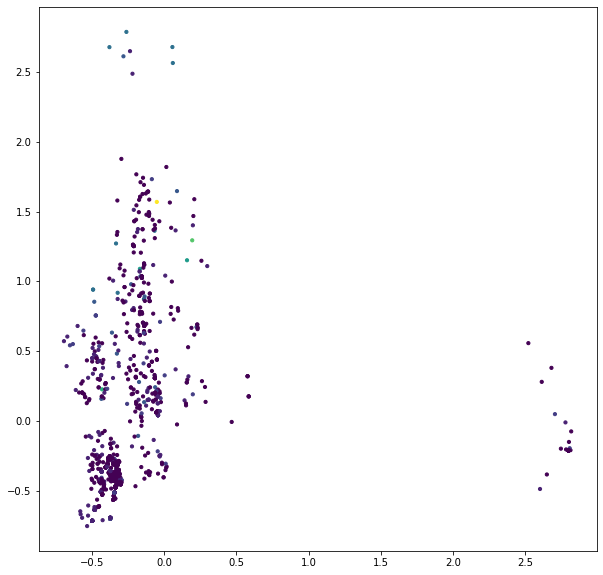

In [130]:
total_blocked = format_df.blocked_chain.apply(lambda x: sum([float(i) for i in x.split(' ')]))

pl.figure(figsize=(10,10))
pl.scatter(pca_model[:,0],pca_model[:,1],s=10,c=total_blocked)

In [34]:
encoded_docs.shape

(91823, 100)